In [1]:
from IPython.display import clear_output
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import os

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_palette(sns.color_palette("Set2"))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Check if GPU is available and output the device name
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available:", gpu_devices)
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU is not available, using CPU instead.")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
train_path = "/kaggle/input/blood-vessel-segmentation/train"
test_path = "/kaggle/input/blood-vessel-segmentation/test"
submis_path = "/kaggle/input/blood-vessel-segmentation/sample_submission.csv"
train_rles_path = "/kaggle/input/blood-vessel-segmentation/train_rles.csv"

In [5]:
base_path = '/kaggle/input/blood-vessel-segmentation/train'
dataset = 'kidney_1_voi'

images_path = os.path.join(base_path, dataset, 'images')
labels_path = os.path.join(base_path, dataset, 'labels')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

def show_images(images, titles=None, cmap='gray'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx], cmap=cmap)
        if titles:
            ax.set_title(titles[idx])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

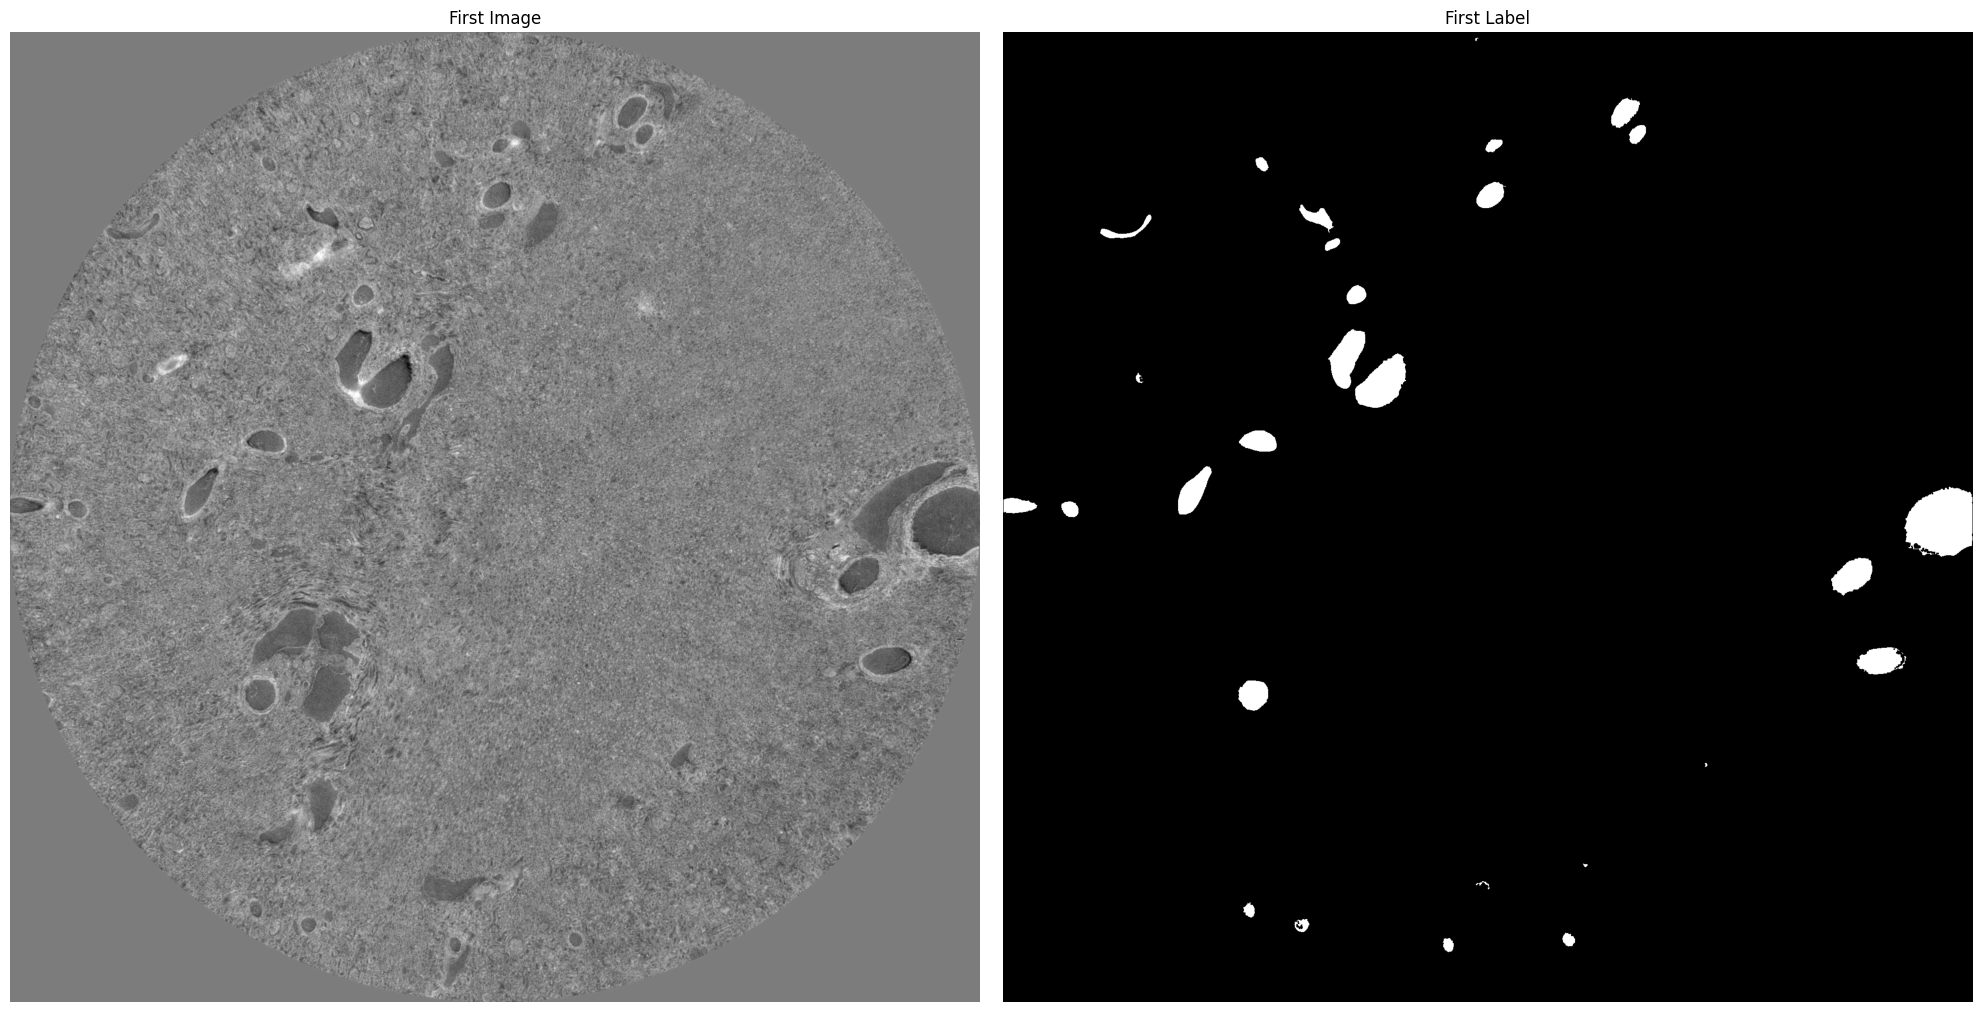

Number of images: 1397
Image shapes: {(1928, 1928)}


In [6]:
first_image = tiff.imread(image_files[0])
first_label = tiff.imread(label_files[0])

show_images([first_image, first_label], titles=['First Image', 'First Label'])

image_shapes = [tiff.imread(file).shape for file in image_files]

print(f"Number of images: {len(image_files)}")
print(f"Image shapes: {set(image_shapes)}")

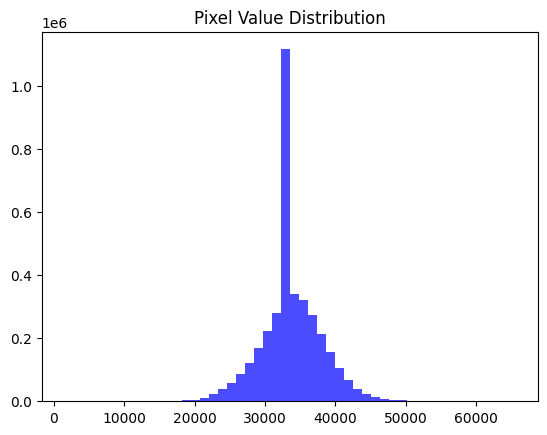

In [7]:
pixel_values = first_image.flatten()
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.show()

In [8]:
def preprocess_image(path):
    image = tiff.imread(path)
    if image.ndim > 2 and image.shape[2] > 1:
        image = image[..., 0]
    
    image = image / 255.0
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    if image_tensor.ndim == 2:
        image_tensor = image_tensor[..., tf.newaxis]
    if image_tensor.ndim != 3:
        raise ValueError('Image tensor must be 3 dimensions [height, width, channels]')
    
    image_tensor = tf.image.resize(image_tensor, [256, 256])
    
    return image_tensor

In [9]:
def preprocess_label(path):
    mask = tiff.imread(path)
    if mask.ndim > 2 and mask.shape[2] > 1:
        mask = mask[..., 0]
        
    mask = mask / 255.0 if mask.max() > 1 else mask
    
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
    
    if mask_tensor.ndim == 2:
        mask_tensor = mask_tensor[..., tf.newaxis]
    if mask_tensor.ndim != 3:
        raise ValueError('Mask tensor must be 3 dimensions [height, width, channels]')
        
    mask_tensor = tf.image.resize(mask_tensor, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask_tensor = tf.where(mask_tensor > 0.5, 1, 0)
    
    return mask_tensor

In [10]:

subsetsize = int(0.2 * (len(image_files)))
subset_images = image_files[:subsetsize]
subset_labels = label_files[:subsetsize]

images = np.array([preprocess_image(f) for f in subset_images])
labels = np.array([preprocess_label(f) for f in subset_labels])

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [11]:
def unet_model(input_shape=(256, 256, 1)):
    inputs = keras.Input(shape=input_shape)

    # Contraction path
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Middle
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path 
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K


def dice_coef(y_true, y_pred):
    smooth = 100
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

**Dice coefficient** Explanation:- The Dice coefficient measures the similarity between the predicted 
segmentation mask (y_pred) and the ground truth mask (y_true). 
The loss function is then used to optimize a segmentation model during training by minimizing 
the dissimilarity (or maximizing the similarity) between the predicted and true masks.

In [13]:
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

**U-Net** Explanation:- U-Net is a convolutional neural network architecture commonly used for image segmentation tasks, particularly in biomedical image analysis. It consists of a contracting path, which captures context through convolutional and pooling layers, followed by an expansive path, which enables precise localization through upsampling and convolutional layers. U-Net's distinctive architecture includes skip connections between corresponding layers in the contracting and expansive paths, allowing the network to retain high-resolution features while capturing context from lower-resolution feature maps. In TensorFlow, U-Net can be implemented using the TensorFlow library, leveraging its powerful tools for defining neural network architectures, training, and inference. This architecture has proven effective for various segmentation tasks, including cell segmentation, organ localization, and medical image segmentation.

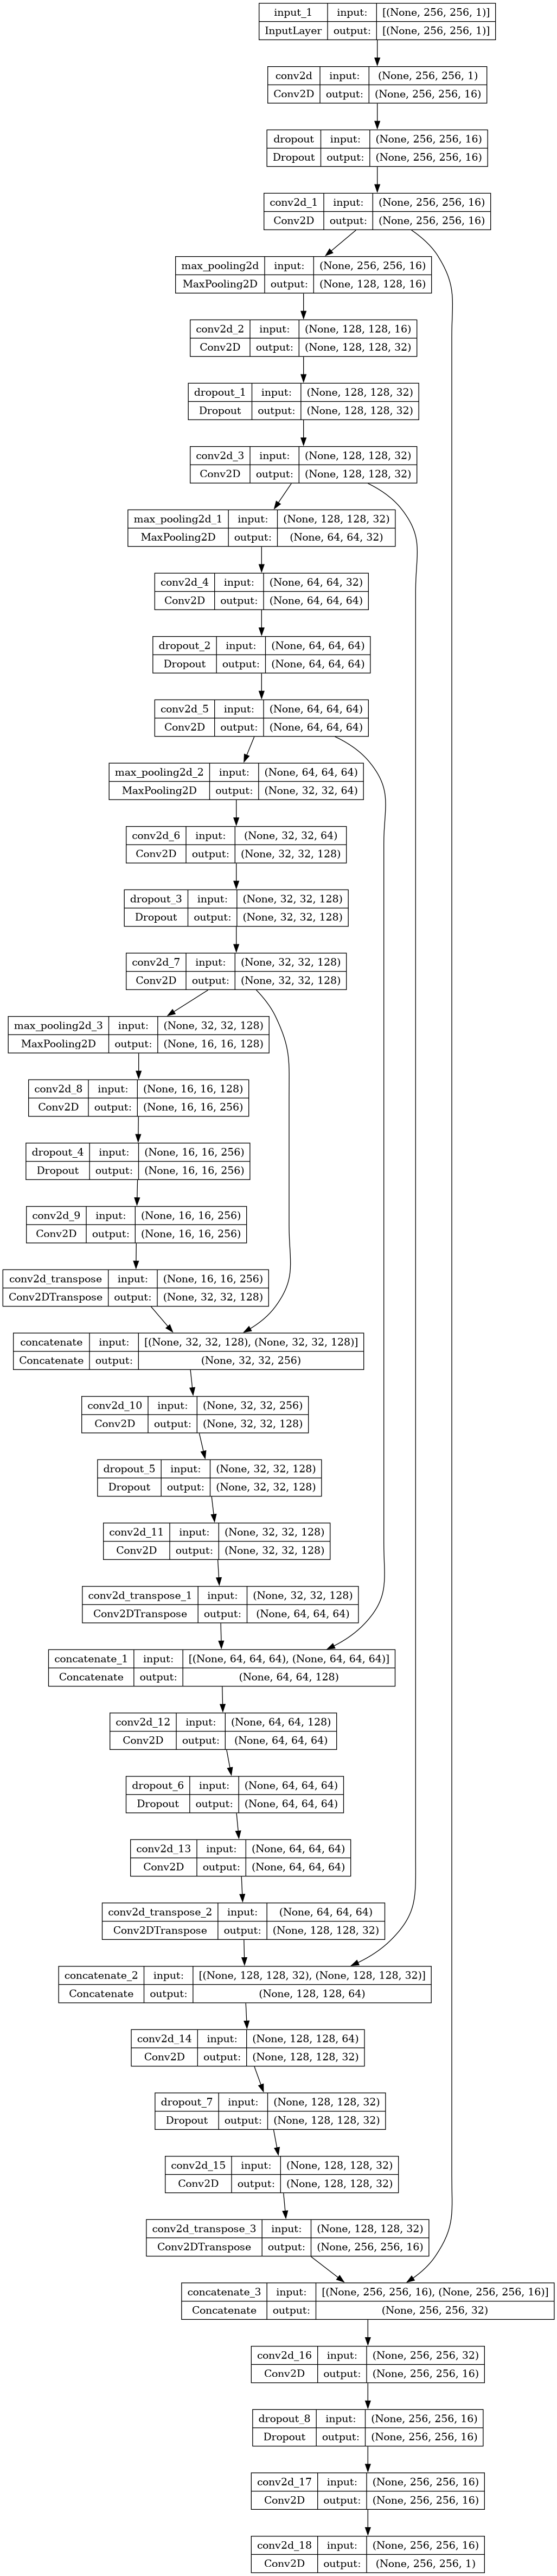

In [14]:
# plot_model(unet, to_file='complete_unet_model.png', show_shapes=True, show_layer_names=True)
plot_model(unet, to_file='complete_unet_model.png', show_shapes=True, show_layer_names=True)

In [15]:
history = unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    epochs=150
)

Epoch 1/150


2024-03-28 12:40:45.187610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 28s 2s/step - loss: 9.0515 - accuracy: 0.9046 - val_loss: 3.4575 - val_accuracy: 0.9872
Epoch 2/150
7/7 [==============================] - 2s 347ms/step - loss: 3.2491 - accuracy: 0.9869 - val_loss: 2.7840 - val_accuracy: 0.9872
Epoch 3/150
7/7 [==============================] - 2s 350ms/step - loss: 2.3292 - accuracy: 0.9851 - val_loss: 1.8679 - val_accuracy: 0.9872
Epoch 4/150
7/7 [==============================] - 2s 353ms/step - loss: 1.4366 - accuracy: 0.9799 - val_loss: 1.0898 - val_accuracy: 0.9872
Epoch 5/150
7/7 [==============================] - 2s 351ms/step - loss: 0.9909 - accuracy: 0.9739 - val_loss: 0.7743 - val_accuracy: 0.9872
Epoch 6/150
7/7 [==============================] - 2s 354ms/step - loss: 0.7929 - accuracy: 0.9710 - val_loss: 0.6053 - val_accuracy: 0.9872
Epoch 7/150
7/7 [==============================] - 2s 354ms/step - loss: 0.6744 - accuracy: 0.9690 - val_loss: 0.5192 - val_accuracy: 0.9872
Epoch 8/150
7/7 [==========

In [16]:
val_loss, val_acc = unet.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc}")

2/2 [==============================] - 0s 58ms/step - loss: 0.0047 - accuracy: 0.9979
Validation Accuracy: 0.9979212880134583


In [17]:
test_base_path = '/kaggle/input/blood-vessel-segmentation/test'
test_image_files = []

for dataset in os.listdir(test_base_path):
    images_path = os.path.join(test_base_path, dataset, 'images')
    if os.path.isdir(images_path):
        test_image_files += sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])

test_images = np.array([preprocess_image(f) for f in test_image_files])

In [18]:
predicted_masks = unet.predict(test_images)
thresholded_masks = (predicted_masks > 0.5).astype(np.uint8)

1/1 [==============================] - 1s 1s/step


In [19]:
import random

num_samples = 5
sample_indices = random.sample(range(len(X_val)), num_samples)

sample_images = X_val[sample_indices]
sample_true_masks = y_val[sample_indices]

sample_pred_masks = unet.predict(sample_images)
sample_pred_masks = (sample_pred_masks > 0.5).astype(np.uint8)

1/1 [==============================] - 1s 791ms/step


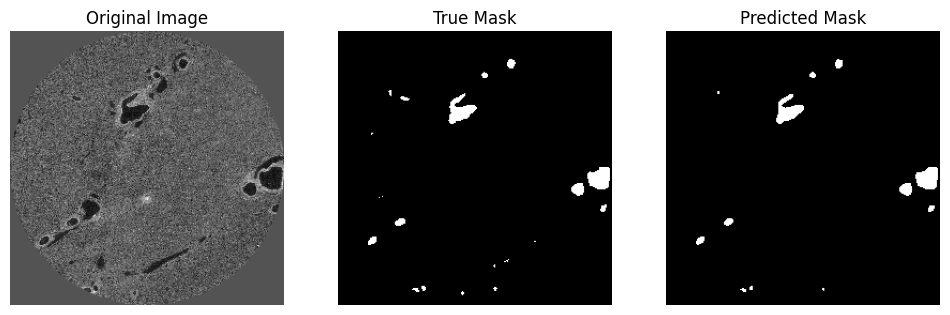

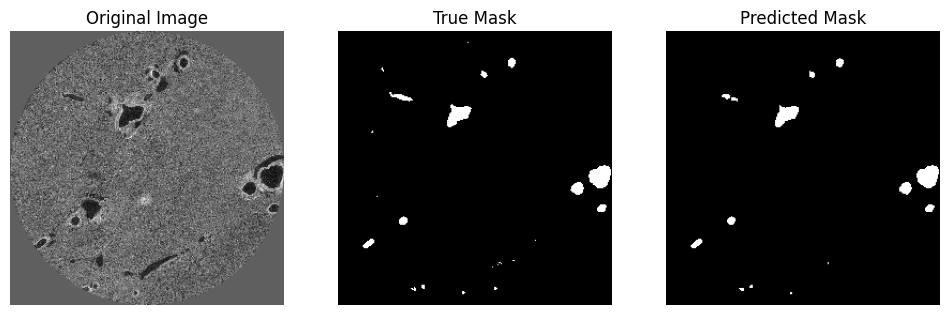

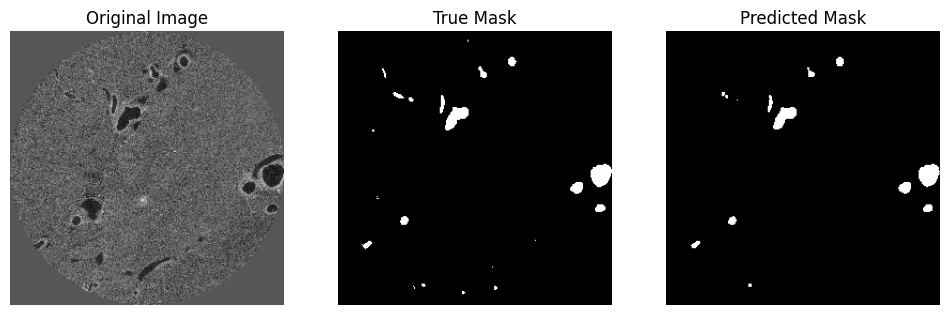

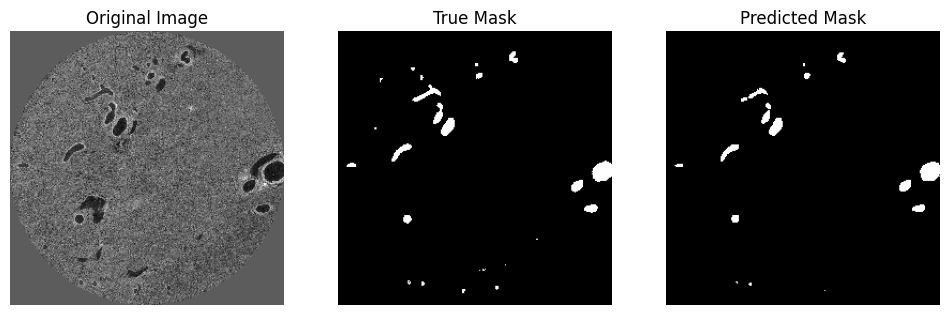

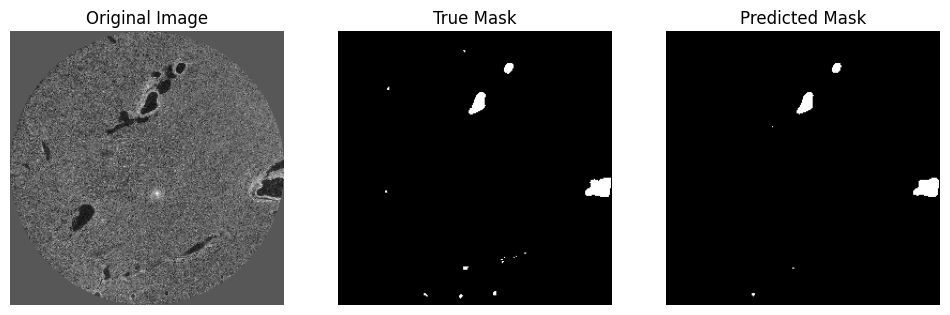

In [20]:
for i in range(num_samples):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sample_true_masks[i], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sample_pred_masks[i], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [21]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle=='':
        rle = '1 0'
    return rle

**RLE Explanation:** For example, the sequence 1 1 1 0 0 1 1 1 1 1 0 0 0 0 would be encoded as 3 1 2 0 5 1 4 0.
The first run is three consecutive 1s, so it's encoded as 3 1.
The next run is two consecutive 0s, so it's encoded as 2 0.
The following run is five consecutive 1s, so it's encoded as 5 1.
The final run is four consecutive 0s, so it's encoded as 4 0.

In [22]:
import pandas as pd

rles = [rle_encode(mask.reshape(256, 256)) for mask in thresholded_masks]
ids = [f'{p.split("/")[-3]}_{os.path.basename(p).split(".")[0]}' for p in test_image_files]

In [23]:
submission = pd.read_csv(submis_path)
submission

,id,rle
0,kidney_5_0000,1 1 100 10
1,kidney_5_0001,1 1 100 10
2,kidney_6_0000,1 0
3,kidney_6_0001,1 0


In [24]:
submission = pd.DataFrame({
    "id": ids,
    "rle": rles
})
submission

,id,rle
0,kidney_5_0000,1 0
1,kidney_5_0001,1 0
2,kidney_5_0002,1 0
3,kidney_6_0000,1 0
4,kidney_6_0001,1 0
5,kidney_6_0002,1 0


In [25]:
submission.to_csv("submission.csv", index=False)